In [71]:
import numpy as np
import matplotlib.pyplot as plt

class TumorGrowthModels:
    def __init__(self, t_data, V_data):
        self.t_data = t_data
        self.V_data = V_data

    # Functie om nepdata te genereren
    @staticmethod
    def generate_fake_data():
        t_data = [0, 13, 20, 32, 42, 55, 65, 75, 85, 88, 95, 98, 107, 115, 120]
        V_data = [250, 255, 550, 575, 576, 800, 1050, 1250, 1750, 2000, 2550, 2750, 3000, 3500, 4000]
        return np.array(t_data), np.array(V_data)

    # Groeimodellen
    @staticmethod
    def logistic_growth(t, V, c, V_max):
        return c * V * (V_max-V)

    @staticmethod
    def gompertz_growth(t, V, c, V_max):
        return c * V * np.log(V_max / V)

    @staticmethod
    def von_bertalanffy_growth(t, V, c, d):
        return c * V**(2/3) - d * V
    
    # Groeimodel van Mendelsohn
    @staticmethod
    def mendelsohn_growth(t, V, c, D):
        return c * V**D
    
    # Groeimodel van Montroll
    @staticmethod
    def montroll_growth(t, V, c, V_max, d):
        return c * V * (V_max**d - V**d)

    @ staticmethod
    def allee_growth(t, V, c, V_min, V_max):
        # Allee effect: growth rate depends on V and the boundaries V_min and V_max
        if V <= V_min or V >= V_max:
            return 0
        return c * (V - V_min) * (V_max - V)


    # Runga methode voor numerieke integratie
    @staticmethod
    def Runga_method(model_growth, t, V0, c, V_max, dt):
        V = [V0]
        for i in range(1, len(t)):
            t_current = t[i - 1]
            V_current = V[-1]
            y1 = dt * model_growth(t_current, V_current, c, V_max)
            y2 = dt * model_growth(t_current + dt / 2, V_current + y1 / 2, c, V_max)
            y3 = dt * model_growth(t_current + dt / 2, V_current + y2 / 2, c, V_max)
            y4 = dt * model_growth(t_current + dt, V_current + y3, c, V_max)
            V_new = V_current + (y1 + 2 * y2 + 2 * y3 + y4) / 6
            V.append(V_new)
        return np.array(V)
    
    def montroll_Runga(self, t, V0, c, V_max, d, dt):
        V = [V0]  # Beginwaarde van het volume
        for i in range(1, len(t)):
            t_current = t[i - 1]
            V_current = V[-1]

            # Bereken de groeisnelheid voor Montroll's model
            y1 = dt * c * V_current * (V_max**d - V_current**d)
            y2 = dt * c * (V_current + y1 / 2) * (V_max**d - (V_current + y1 / 2)**d)
            y3 = dt * c * (V_current + y2 / 2) * (V_max**d - (V_current + y2 / 2)**d)
            y4 = dt * c * (V_current + y3) * (V_max**d - (V_current + y3)**d)

            # Bereken de nieuwe waarde van V
            V_new = V_current + (y1 + 2 * y2 + 2 * y3 + y4) / 6
            V.append(V_new)

        return np.array(V)
    
    def allee_Runga(self, t, V0, c, V_min, V_max, dt):
        V = [V0]  # Beginwaarde van het volume
        for i in range(1, len(t)):
            t_current = t[i - 1]
            V_current = V[-1]

            # Bereken de groeisnelheid voor het Allee-effect model (direct in de Runga methode)
            y1 = dt * c * (V_current - V_min) * (V_max - V_current)
            y2 = dt * c * (V_current + y1 / 2 - V_min) * (V_max - (V_current + y1 / 2))
            y3 = dt * c * (V_current + y2 / 2 - V_min) * (V_max - (V_current + y2 / 2))
            y4 = dt * c * (V_current + y3 - V_min) * (V_max - (V_current + y3))

            # Bereken de nieuwe waarde van V
            V_new = V_current + (y1 + 2 * y2 + 2 * y3 + y4) / 6
            V.append(V_new)

        return np.array(V)
            


    def gompertz_Runga(self, t, V0, c, V_max, dt):
        return self.Runga_method(self.gompertz_growth, t, V0, c, V_max, dt)

    def logistic_Runga(self, t, V0, c, V_max, dt):
        return self.Runga_method(self.logistic_growth, t, V0, c, V_max, dt)

    def von_bertalanffy_runga(self, t, V0, c, d, dt):
        return self.Runga_method(self.von_bertalanffy_growth, t, V0, c, d, dt)
    
    def mendelsohn_Runga(self, t, V0, c, D, dt):
        return self.Runga_method(self.mendelsohn_growth, t, V0, c, D, dt)
    
    def montroll_Runge(self, t, V0, c, V_max, d, dt):
        return self.montroll_Runga(self.montroll_growth, t, V0, c, V_max, d, dt)
    
    def runga_allee(self, t, V0, c, V_min, V_max, dt):
        return self.allee_Runga(self.allee_growth, t, V0, c, V_min, V_max, dt)


    # Wrapper functies voor model fitting
    @staticmethod
    def logistic_wrapper(t, c, V_max,V_data):
        V0 = V_data[0] 
        dt = t[1] - t[0]
        V = [V0]
        for i in range(1, len(t)):
            V_new = V[-1] + dt * TumorGrowthModels.logistic_growth(t[i], V[-1], c, V_max)
            V.append(V_new)
        return np.array(V)

    @staticmethod
    def gompertz_wrapper(t, c, V_max, V_data):
        V0 = V_data[0]  
        dt = t[1] - t[0]
        V = [V0]
        for i in range(1, len(t)):
            V_new = V[-1] + dt * TumorGrowthModels.gompertz_growth(t[i], V[-1], c, V_max)
            V.append(V_new)
        return np.array(V)

    @staticmethod
    def von_bertalanffy_wrapper(t, c, d,V_data):
        V0 = V_data[0]  
        dt = t[1] - t[0]
        V = [V0]
        for i in range(1, len(t)):
            V_new = V[-1] + dt * TumorGrowthModels.von_bertalanffy_growth(t[i], V[-1], c, d)
            V.append(V_new)
        return np.array(V)
    @staticmethod
    def mendelsohn_wrapper(t, c, D, V_data):
        V0 = V_data[0]  # Eerste waarde van V als startwaarde
        dt = t[1] - t[0]
        V = [V0]
        for i in range(1, len(t)):
            V_new = V[-1] + dt * TumorGrowthModels.mendelsohn_growth(t[i], V[-1], c, D)
            V.append(V_new)
        return np.array(V)

    @staticmethod
    def montroll_wrapper(t, c, V_max, d, V_data):
        V0 = V_data[0]  # Eerste waarde van V als startwaarde
        dt = t[1] - t[0]
        V = [V0]
        for i in range(1, len(t)):
            V_new = V[-1] + dt * TumorGrowthModels.montroll_growth(t[i], V[-1], c, V_max, d)
            V.append(V_new)
        return np.array(V)

    @staticmethod
    def allee_wrapper(t, c, V_min, V_max, V_data):
        V0 = V_data[0]  # Eerste waarde van V als startwaarde
        dt = t[1] - t[0]
        V = [V0]
        for i in range(1, len(t)):
            V_new = V[-1] + dt * TumorGrowthModels.allee_growth(t[i], V[-1], c, V_min, V_max)
            V.append(V_new)
        return np.array(V)
    
    # Fit model met brute force
    @staticmethod
    def fit_model_brute_force(model_wrapper, t_data, V_data, p0, num_iterations=10000, step_size=0.01):
        def model(t, *params):
            return model_wrapper(t, *params, V_data)

        best_params = p0
        best_cost = np.sum((model(t_data, *best_params) - V_data) ** 2)

        for _ in range(num_iterations):
            new_params = best_params + np.random.uniform(-step_size, step_size, len(p0))
            cost = np.sum((model(t_data, *new_params) - V_data) ** 2)

            # Gradients can be used here for more informed steps, rather than random perturbation
            if cost < best_cost:
                best_params = new_params
                best_cost = cost

        return best_params

    # AIC en BIC berekeningen
    @staticmethod
    def calculate_aic(n, rss, k):
        return n * np.log(rss / n) + 2 * k

    @staticmethod
    def calculate_bic(n, rss, k):
        return n * np.log(rss / n) + k * np.log(n)

    @staticmethod
    def calculate_residuals(V_data, V_sim):
        residuals = V_data - V_sim
        rss = np.sum(residuals**2)
        return rss

    # Model evaluatie, selectie en visualisatie
    def evaluate_models(self, t_vooruit=None):
        # Als t_vooruit niet wordt meegegeven, gebruik de standaardwaarde
        if t_vooruit is None:
            t_vooruit = np.linspace(0, 120, len(self.ts))  # Standaardtijdspanne van 0 tot 120 dagen met 100 punten



        # Pas modellen aan
        params_mendelsohn = self.fit_model_brute_force(self.mendelsohn_wrapper, self.t_data, self.V_data, p0=[0.01, 0.1], num_iterations=10000)
        params_gompertz = self.fit_model_brute_force(self.gompertz_wrapper, self.t_data, self.V_data, p0=[0.11, 7.7], num_iterations=10000)
        params_logistic = self.fit_model_brute_force(self.logistic_wrapper, self.t_data, self.V_data, p0=[0.01, 7], num_iterations=10000)
        params_von_bertalanffy = self.fit_model_brute_force(self.von_bertalanffy_wrapper, self.t_data, self.V_data, p0=[0.5,0.2], num_iterations=10000)
        params_montroll = self.fit_model_brute_force(self.montroll_wrapper, self.t_data, self.V_data, p0=[0.01, 8, 0.1], num_iterations=10000)
        params_allee = self.fit_model_brute_force(self.allee_wrapper, self.t_data, self.V_data, p0=[0.05, 0, 7.5], num_iterations=10000)
        # Simuleer data
        dt = t_vooruit[1] - t_vooruit[0]
        V_sim_gompertz = self.gompertz_Runga(t_vooruit, self.V_data[0], *params_gompertz, dt)
        V_sim_logistic = self.logistic_Runga(t_vooruit, self.V_data[0], *params_logistic, dt)
        V_sim_von_bertalanffy = self.von_bertalanffy_runga(t_vooruit, self.V_data[0], *params_von_bertalanffy, dt)
        V_sim_mendelsohn = self.mendelsohn_Runga(t_vooruit, self.V_data[0], *params_mendelsohn, dt)
        V_sim_montroll = self.montroll_Runga(t_vooruit, self.V_data[0], *params_montroll, dt)
        V_sim_allee = self.allee_Runga(t_vooruit, self.V_data[0], *params_allee, dt)
        # Fit Montroll's model met brute force
        


        # Visualisatie
        plt.figure(figsize=(10, 6))
        plt.scatter(self.t_data, self.V_data, color="red", label="Data")
        plt.plot(t_vooruit, V_sim_mendelsohn, label=f"Mendelsohn Model, params={params_mendelsohn}", color="orange")
        plt.plot(t_vooruit, V_sim_gompertz, label=f"Gompertz Model, params={params_gompertz}", color="blue")
        plt.plot(t_vooruit, V_sim_logistic, label=f"Logistic Model, params={params_logistic}", color="green")
        plt.plot(t_vooruit, V_sim_von_bertalanffy, label=f"Von Bertalanffy Model, params={params_von_bertalanffy}", color="purple")
        plt.plot(t_vooruit, V_sim_montroll, label=f"Montroll Model, params={params_montroll}", color="pink")
        plt.plot(t_vooruit, V_sim_allee, label=f"Allee Effect Model, params={params_allee}", color="brown")
        plt.title("Tumorgroei Modellen vs. Data")
        plt.xlabel("Tijd (dagen)")
        plt.ylabel("Tumorvolume (mm³)")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Bereken AIC en BIC
        rss_gompertz = self.calculate_residuals(self.V_data,self.gompertz_wrapper(self.t_data, *params_gompertz, self.V_data))
        rss_logistic = self.calculate_residuals(self.V_data, self.logistic_wrapper(self.t_data, *params_logistic,self.V_data))
        rss_von_bertalanffy = self.calculate_residuals(self.V_data, self.von_bertalanffy_wrapper(self.t_data, *params_von_bertalanffy,self.V_data))

        n = len(self.V_data)
        k_gompertz = len(params_gompertz)
        k_logistic = len(params_logistic)
        k_von_bertalanffy = len(params_von_bertalanffy)

        aic_gompertz = self.calculate_aic(n, rss_gompertz, k_gompertz)
        bic_gompertz = self.calculate_bic(n, rss_gompertz, k_gompertz)
        aic_logistic = self.calculate_aic(n, rss_logistic, k_logistic)
        bic_logistic = self.calculate_bic(n, rss_logistic, k_logistic)
        aic_von_bertalanffy = self.calculate_aic(n, rss_von_bertalanffy, k_von_bertalanffy)
        bic_von_bertalanffy = self.calculate_bic(n, rss_von_bertalanffy, k_von_bertalanffy)

        rss_mendelsohn = self.calculate_residuals(self.V_data, self.mendelsohn_wrapper(self.t_data, *params_mendelsohn, self.V_data))
        aic_mendelsohn = self.calculate_aic(n, rss_mendelsohn, len(params_mendelsohn))
        bic_mendelsohn = self.calculate_bic(n, rss_mendelsohn, len(params_mendelsohn))

        rss_montroll = self.calculate_residuals(self.V_data, self.montroll_wrapper(self.t_data, *params_montroll,self.V_data))
        aic_montroll = self.calculate_aic(n,rss_montroll,len(params_montroll))
        bic_montroll = self.calculate_bic(n,rss_montroll,len(params_montroll))

        rss_allee = self.calculate_residuals(self.V_data, self.allee_wrapper(self.t_data, *params_allee,self.V_data))
        aic_allee = self.calculate_aic(n,rss_allee,len(params_allee))
        bic_allee = self.calculate_bic(n,rss_allee,len(params_allee))



        import pandas as pd

        # Voorbeeld van AIC en BIC waarden
        models = ['Gompertz', 'Logistic', 'Von Bertalanffy', 'Mendelsohn', 'Montroll','allee']
        aic_values = [aic_gompertz, aic_logistic, aic_von_bertalanffy, aic_mendelsohn, aic_montroll,aic_allee]
        bic_values = [bic_gompertz, bic_logistic, bic_von_bertalanffy, bic_mendelsohn, bic_montroll,bic_allee]

        # Creëer een DataFrame
        df = pd.DataFrame({
            'Model': models,
            'AIC': aic_values,
            'BIC': bic_values
        })

        # Sorteer de tabel op AIC (of BIC)
        df_sorted_aic = df.sort_values(by='AIC', ascending=True)  # Sorteer van hoog naar laag AIC
        df_sorted_bic = df.sort_values(by='BIC', ascending=True)  # Sorteer van hoog naar laag BIC

        # Print de gesorteerde tabellen
        print("AIC gesorteerd van laag naar hoog:")
        print(df_sorted_aic)

        print("\nBIC gesorteerd van laag naar hoog:")
        print(df_sorted_bic)

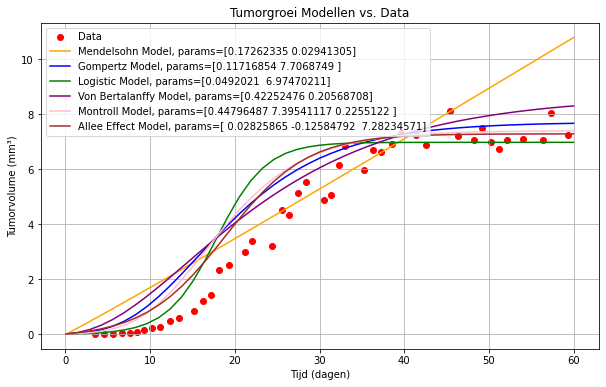

AIC gesorteerd van laag naar hoog:
             Model        AIC        BIC
4         Montroll -94.509107 -89.089120
5            allee -89.062595 -83.642608
0         Gompertz -85.663201 -82.049876
1         Logistic -56.188416 -52.575091
2  Von Bertalanffy -51.455916 -47.842591
3       Mendelsohn  -5.104418  -1.491093

BIC gesorteerd van laag naar hoog:
             Model        AIC        BIC
4         Montroll -94.509107 -89.089120
5            allee -89.062595 -83.642608
0         Gompertz -85.663201 -82.049876
1         Logistic -56.188416 -52.575091
2  Von Bertalanffy -51.455916 -47.842591
3       Mendelsohn  -5.104418  -1.491093


In [ ]:

import numpy as np

# Stel zelf tijd en volume data in
ts = [
     3.46,  4.58,  5.67,  6.64,  7.63,  8.41,  9.32, 10.27, 11.19,
    12.39, 13.42, 15.19, 16.24, 17.23, 18.18, 19.29, 21.23, 21.99,
    24.33, 25.58, 26.43, 27.44, 28.43, 30.49, 31.34, 32.34, 33.00,
    35.20, 36.34, 37.29, 38.50, 39.67, 41.37, 42.58, 45.39, 46.38,
    48.29, 49.24, 50.19, 51.14, 52.10, 54.00, 56.33, 57.33, 59.38,
]
Vs = [
    0.0158, 0.0264, 0.0326, 0.0445, 0.0646, 0.0933, 0.1454, 0.2183, 0.2842,
    0.4977, 0.6033, 0.8441, 1.2163, 1.4470, 2.3298, 2.5342, 3.0064, 3.4044,
    3.2046, 4.5241, 4.3459, 5.1374, 5.5376, 4.8946, 5.0660, 6.1494, 6.8548,
    5.9668, 6.6945, 6.6395, 6.8971, 7.2966, 7.2268, 6.8815, 8.0993, 7.2112,
    7.0694, 7.4971, 6.9974, 6.7219, 7.0523, 7.1095, 7.0694, 8.0562, 7.2268, 
]

# Maak een model aan met je eigen data
model = TumorGrowthModels(ts, Vs)

# Pas de tijdspanne en aantal punten aan
t_vooruit = np.linspace(0.1, 60, len(ts))  

# Voer model evaluatie uit en visualiseer de resultaten
model.evaluate_models(t_vooruit)